This notebook extracts and exports various measures of task behaviour from the log data of the JUSThink Dialogue and Actions Corpus, at varying granularities of the activity (i.e. Corpus, Task, Attempt, and Turn Levels).

In later notebooks, we focus one feature to estimate the task performance: (minimum) error.

We define the granularities as follows:
1. Corpus Level:  The whole collection of temporal team action data (logs) for all teams
1. Task level: The complete time that a team participates in the activity
2. Attempt level: The duration of the team constructing a solution and submitting it together
3. Turn level: The duration where one of the participants is in figurative view, and the other is in abstract view

Note that the levels Task, Attempt and Turn are time granularities for a team.

In [1]:
import pathlib as pl
import networkx as nx
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from read_utils import read_tables, read_network

In [2]:
import read_utils

In [3]:
plt.rcParams['font.family'] = "serif"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

## Define paths.

In [4]:
# Inputs.
data_dir = pl.Path('../data')
network_file = data_dir.joinpath('metadata/network.json')
logs_dir = data_dir.joinpath('logs')

# Outputs.
processed_data_dir = pl.Path('../processed_data')
output_dir = processed_data_dir.joinpath('log_features')

# Create output directories if they do not exist.
for folder in [output_dir]:
    if not folder.exists():
        folder.mkdir(parents=True)

## Load data.

### Load logs.

In [5]:
log_dfs = read_tables(logs_dir, form='log')

Reading log files from ../data/logs.
log 39 files found.
File justhink19_log_06 belongs to team  6
File justhink19_log_07 belongs to team  7
File justhink19_log_08 belongs to team  8
File justhink19_log_09 belongs to team  9
File justhink19_log_10 belongs to team 10
File justhink19_log_11 belongs to team 11
File justhink19_log_12 belongs to team 12
File justhink19_log_14 belongs to team 14
File justhink19_log_15 belongs to team 15
File justhink19_log_16 belongs to team 16
File justhink19_log_17 belongs to team 17
File justhink19_log_18 belongs to team 18
File justhink19_log_19 belongs to team 19
File justhink19_log_20 belongs to team 20
File justhink19_log_21 belongs to team 21
File justhink19_log_22 belongs to team 22
File justhink19_log_23 belongs to team 23
File justhink19_log_25 belongs to team 25
File justhink19_log_26 belongs to team 26
File justhink19_log_27 belongs to team 27
File justhink19_log_28 belongs to team 28
File justhink19_log_29 belongs to team 29
File justhink19_log

### Combine the log tables into a corpus.

In [6]:
data_df = pd.concat(log_dfs.values(), ignore_index=True)
data_df.insert(2, 'corpus_no', 1)

### Load the network.

In [7]:
network = read_network(network_file)
print('Network read from {}: {} nodes, {} edges'.format(
    network_file, network.number_of_nodes(), network.number_of_edges()))

Network read from ../data/metadata/network.json: 10 nodes, 20 edges


#### Visualize the network.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

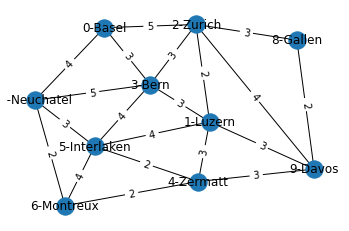

In [8]:
def draw_network(G, labels=None):
    x_values = nx.get_node_attributes(G, 'x')
    y_values = nx.get_node_attributes(G, 'y')

    pos = {u: (x_values[u], y_values[u]) for u in G.nodes()}

    fig, ax = plt.subplots()

    if labels is None:
        labels = {u: '{}-{}'.format(u, d['label'].split()[-1])
                  for u, d in G.nodes(data=True)}

    nx.draw(G,
            pos=pos,
            with_labels=True,
            labels=labels,
            nodelist=[u for u in G.nodes()],
            ax=ax)

    labels = nx.get_edge_attributes(G, 'cost')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax.margins(0.1)

    return fig, ax


draw_network(network)

### Find the optimal solutions.
i.e. minimum spanning trees.

#### Find a minimum spanning tree.

MST found, 10 nodes, 9 edges, cost = 22


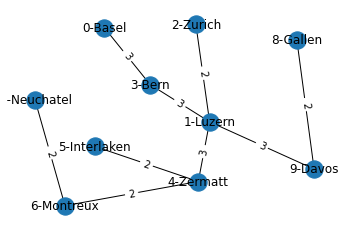

In [9]:
def solve_mst(G, weight_key='cost'):
    return nx.minimum_spanning_tree(G, weight=weight_key)


def calculate_network_cost(G):
    return sum([d['cost'] for u, v, d in G.edges(data=True) if 'cost' in d])


def calculate_edge_set_cost(edge_set, G):
    return sum([G[u][v]['cost'] for u, v in edge_set])


mst_network = solve_mst(network)
mst_network.graph['cost'] = calculate_network_cost(mst_network)

print('MST found, {} nodes, {} edges, cost = {}'.format(
    mst_network.number_of_nodes(), mst_network.number_of_edges(),
    mst_network.graph['cost']))

draw_network(mst_network)
optimal_cost = mst_network.graph['cost']

#### Construct the second one manually.

Alternative MST constructed, 10 nodes, 9 edges, cost = 22


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

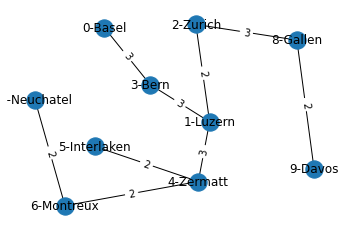

In [10]:
mst_network_2 = mst_network.copy()
mst_network_2.add_edge(2, 8, cost=3)
mst_network_2.remove_edge(1, 9)

mst_network_2.graph['cost'] = calculate_network_cost(mst_network_2)
print('Alternative MST constructed, {} nodes, {} edges, cost = {}'.format(
    mst_network_2.number_of_nodes(), mst_network_2.number_of_edges(),
    mst_network_2.graph['cost']))

draw_network(mst_network_2)

### Extract features from logs.

Make a tables object to hold the data and computed feature tables.

In [11]:
tables = {'data': data_df}

Compute time difference between the time of consecutive event pairs.
To be used for computing duration later.

In [12]:
durations = lambda x: x['time'].diff().fillna(0)
data_df['duration'] = data_df.groupby('team_no').apply(durations).reset_index(drop=True)

### Create groups that represent the different granularities (levels of analysis).

In [13]:
levels = {
    'corpus': data_df.groupby('corpus_no'),
    'task': data_df.groupby(['corpus_no', 'team_no']), 
    'attempt': data_df.groupby(['corpus_no', 'team_no', 'attempt_no']), 
    'turn': data_df.groupby(['team_no', 'attempt_no', 'turn_no']),
}

### Define the features as functions.

In [14]:
# Performance Features

def success(x, opt_cost=optimal_cost):
    '''whether a team has succeeded i.e. found the optimal solution, at task level only'''
   # return x.name[-1] in metadata['success']
    c = cost(x)
    return not np.isnan(c) and c == opt_cost


def cost(x):
    '''the sum of the edge costs of the submitted solution'''
    submits = x[x['verb'].isin(['submits'])]
    if len(submits) > 0:
        return int(submits['object'].iloc[-1].split()[0].split('=')[-1])
    else:
        return np.nan


def abs_error(x, opt_cost=optimal_cost):
    '''absolute error, i.e. the difference between the cost of the submitted solution and the cost of an optimal/correct solution (optimal cost)'''
    return (cost(x) - opt_cost)


def error(x, opt_cost=optimal_cost):
    '''relative error, i.e. absolute error divided by the optimal cost'''
    return 1.0 * (cost(x) - opt_cost) / opt_cost

# Task/Attempt/Turn/Event Counts


def num_task(x):
    '''number of tasks, where a task is 
    the complete period that a team plays to find an optimal solution'''
    return len(x['team_no'].unique())


def num_attempt(x):
    '''number of attempts, where an attempt is the duration of the team constructing a solution and submitting it together as a proposal'''
    return len(x['attempt_no'].unique())


def num_turn(x):
    '''number of turns, where a turn is the duration where one player is in figurative view and the other player is in abstract view'''
    return len(x['turn_no'].unique())


def num_action(x):
    '''number of actions, where an action is something done by the players or the tutor.'''
    return len(x['subject'].isin(['A', 'B', 'R']))


def avg_turn(x):
    '''number of turns normalized by the number of attempts'''
    return 1.0 * num_turn(x) / num_attempt(x)


def avg_action_per_turn(x):
    '''number of actions normalized by the number of turns'''
    return 1.0 * num_action(x) / num_turn(x)


# Duration Related


def start(x):
    '''start time in seconds'''
    return x['time'].iloc[0]


def end(x):
    '''end time in seconds'''
    return x['time'].iloc[-1]


def duration(x):
    '''total time (in seconds) spent in the task until finding the optimal solution or time-up intervention'''
    return x['duration'].sum()


# Features on Edit Actions


def num_add(x):
    '''number of additions'''
    return x['verb'].isin(['adds']).sum()


def num_del(x):
    '''number of deletions'''
    return x['verb'].isin(['removes']).sum()


def num_edit(x):
    '''number of edits (additions and deletions) on the graph'''
    return num_add(x) + num_del(x)


def freq_add(x):
    '''relative frequency of additions, as divided by the total number of additions and deletions'''
    n = num_edit(x)
    if n == 0:
        return -1
    else:
        return 1.0 * num_add(x) / n


def freq_del(x):
    '''relative frequency of deletions, as normalized by the total number of additions and deletions'''
    return 1 - freq_add(x)

def num_histload(x):
    ''' how many times a previous solution was loaded i.e. brought back'''
    return x['object'].isin(['apply (enabled)']).sum()


def freq_histload(x):
    '''relative frequency of the previous solution was bring-backs 
    as normalized by the number of times the previous solutions were shown'''
    n = num_histview(x)
    if n == 0:
        return -1
    else:
        return 1.0 * num_histload(x) / n

# Evaluation Actions


def num_submitselect(x):
    '''number of times the current solution is selected for submission'''
    return x['object'].isin(['submit (disabled)']).sum()


def num_histview(x):
    '''number of times the player opens to view the solutions history'''
    return x['object'].isin(['compare (enabled)']).sum()


def num_histnext(x):
    '''number of times the player chooses to view the next solution in the solutions history'''
    return x['object'].isin(['next (enabled)']).sum()


def num_histprev(x):
    '''number of times the player chooses to view the previous solution in the solutions history'''
    return x['object'].isin(['previous (enabled)']).sum()


def num_histnavi(x):
    '''number of times the player chooses to navigate (view next or view previous)  
    among the solutions in the solutions history'''
    return num_histnext(x) + num_histprev(x)

# Other


def num_help(x):
    '''number of times a player opened help/info window'''
    return x['object'].isin(['help (enabled)']).sum()


def last_valid_value(x):
    '''the error of the last completed attempt'''
    return x.iloc[-1] if not np.isnan(x.iloc[-1]) else x.iloc[-2]


def series_range(x):
    #     x = x[1:]
    '''maximum - minimum of the sequence'''
    return np.max(x) - np.min(x)


def series_slope(x):
    #     x = x[1:]
    '''(simple linear) regression coefficient (i.e. slope) of the sequence'''
    x = x[~np.isnan(x)]
    if len(np.unique(x)) == 1:
        return 0.0
    y = np.arange(len(x))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope


def series_noninc(x):
    '''True if the sequence is non-increasing, False otherwise.'''
    for i in range(len(x) - 1):
        if x.iloc[i+1] > x.iloc[i]:
            return False
    return True


def compute_features(grouped, functions=[], df=None, inplace=False, insert_index=None):
    '''Computes features on a grouped object from a list of functions'''
    if df is not None and not inplace:
        df = df.copy()

    if insert_index is not None:
        functions.reverse()

    for i, entry in enumerate(functions):
        if callable(entry):  # if it is a function
            # Print the name of the function.
            s = entry.__name__ if hasattr(entry, '__name__') else entry
            print('Computing feature {}'.format(s))
            
            func = entry
            result_column = func.__name__

            if df is None and i == 0:
                df = grouped.apply(func).to_frame(func.__name__)
            else:
                i = len(df.columns) if insert_index is None else insert_index
                df.insert(i, result_column, grouped.apply(func))

        elif type(entry) is list:
            applied_column, prefix_func_pairs = entry

            if insert_index is not None:
                prefix_func_pairs.reverse()

            for prefix, func in prefix_func_pairs:
                result_column = '{}_{}'.format(prefix, applied_column)
                
                # Print the name of the function.
                print('Computing feature {}'.format(result_column))

                i = len(df.columns) if insert_index is None else insert_index

                if df is None and i == 0:
                    df = grouped[applied_column].apply(
                        func).to_frame(result_column)
                else:
                    df.insert(i, result_column,
                              grouped[applied_column].apply(func))

    return df

### Compute attempt level features.

In [15]:
# Compute task features.
attempt_features = [
    cost, abs_error, error,
    # Attempt/Turn/Event Counts
    num_turn, num_action,
    # Time Related
    duration, start, end,
#     # Edit Action Related
    num_add, num_del, num_edit, freq_add, freq_del, num_histload, freq_histload,
#     # Evaluation Action Related
#     num_submitselect, num_histview, num_histnext, num_histprev, num_histnavi,
#     # Other
#     num_help,
    success,
    ]
tables['attempt'] = compute_features(levels['attempt'], attempt_features)

# Display the task features table.
tables['attempt'].head(10)

Computing feature cost
Computing feature abs_error
Computing feature error
Computing feature num_turn
Computing feature num_action
Computing feature duration
Computing feature start
Computing feature end
Computing feature num_add
Computing feature num_del
Computing feature num_edit
Computing feature freq_add
Computing feature freq_del
Computing feature num_histload
Computing feature freq_histload
Computing feature success


cost  abs_error     error  num_turn  num_action  \
corpus_no team_no attempt_no                                                    
1         6       1           24.0        2.0  0.090909        21          72   
                  2           22.0        0.0  0.000000         8          28   
          7       1           64.0       42.0  1.909091        14          50   
                  2           64.0       42.0  1.909091         4          23   
                  3           29.0        7.0  0.318182         6          16   
                  4           30.0        8.0  0.363636         8          21   
                  5           31.0        9.0  0.409091         7          23   
                  6           31.0        9.0  0.409091        10          24   
                  7           31.0        9.0  0.409091         6          18   
                  8           30.0        8.0  0.363636         8          30   

                              duration     start       end  num_add  num_del  \
corpus_no team_no attempt_no                                                   
1         6       1           1013.047     0.122  1013.169       25       16   
                  2            337.414  1025.061  1350.583       12        3   
          7       1            264.240     0.315   264.555       23        3   
                  2             75.149   277.949   339.704        5        2   
                  3             45.036   355.730   384.740       10        0   
                  4            103.876   397.215   488.616       12        2   
                  5             90.407   501.269   579.023       11        1   
                  6             94.255   586.504   673.278       14        4   
                  7             58.610   697.498   731.888       10        0   
                  8             66.548   742.335   798.436       12        3   

                              num_edit  freq_add  freq_del  num_histload  \
corpus_no team_no attempt_no                                               
1         6       1                 41  0.609756  0.390244             0   
                  2                 15  0.800000  0.200000             0   
          7       1                 26  0.884615  0.115385             0   
                  2                  7  0.714286  0.285714             5   
                  3                 10  1.000000  0.000000             0   
                  4                 14  0.857143  0.142857             0   
                  5                 12  0.916667  0.083333             0   
                  6                 18  0.777778  0.222222             0   
                  7                 10  1.000000  0.000000             0   
                  8                 15  0.800000  0.200000             0   

                              freq_histload  success  
corpus_no team_no attempt_no                          
1         6       1               -1.000000    False  
                  2                0.000000     True  
          7       1               -1.000000    False  
                  2                1.666667    False  
                  3               -1.000000    False  
                  4               -1.000000    False  
                  5               -1.000000    False  
                  6               -1.000000    False  
                  7               -1.000000    False  
                  8               -1.000000    False

### Compute task level features.

In [16]:
# Compute task features.
task_features = [
    success,
    # Attempt/Turn/Event Counts
    num_attempt, avg_turn, avg_action_per_turn, num_turn, num_action,
    # Time Related
    duration,
    # Edit Action Related
    # num_add, num_del, 
    num_edit, freq_add, 
    #freq_del, num_histload, 
    freq_histload,
    # Evaluation Action Related
    num_submitselect, 
    num_histview,
    # num_histnext, num_histprev, num_histnavi,
    # Other
    num_help,
    ]
tables['task'] = compute_features(levels['task'], task_features)

attempt_to_task_features = [
    ['error', [
        ('last', last_valid_value),
        ('max', np.max),
        ('min', np.min),
        ('range', series_range),
        ('avg', np.mean),
        ('std', np.std), 
        ('noninc', series_noninc),
        ('slope', series_slope),
        ]
    ], 
]
grouped = tables['attempt'].reset_index().groupby(['corpus_no', 'team_no'])
insert_index = 0
compute_features(grouped, attempt_to_task_features, df=tables['task'], 
                 insert_index=insert_index, inplace=True)

# Display the task features table.
tables['task'].head(10)

Computing feature success
Computing feature num_attempt
Computing feature avg_turn
Computing feature avg_action_per_turn
Computing feature num_turn
Computing feature num_action
Computing feature duration
Computing feature num_edit
Computing feature freq_add
Computing feature freq_histload
Computing feature num_submitselect
Computing feature num_histview
Computing feature num_help
Computing feature slope_error
Computing feature noninc_error
Computing feature std_error
Computing feature avg_error
Computing feature range_error
Computing feature min_error
Computing feature max_error
Computing feature last_error


last_error  max_error  min_error  range_error  avg_error  \
corpus_no team_no                                                             
1         6          0.000000   0.090909   0.000000     0.090909   0.045455   
          7          0.136364   1.909091   0.136364     1.772727   0.505051   
          8          0.409091   0.500000   0.136364     0.363636   0.308081   
          9          0.318182   0.363636   0.045455     0.318182   0.234848   
          10         0.454545   0.681818   0.136364     0.545455   0.318182   
          11         0.136364   1.909091   0.045455     1.863636   0.586777   
          12         0.181818   0.681818   0.045455     0.636364   0.306818   
          14         0.136364   0.909091   0.136364     0.772727   0.397727   
          15         0.409091   0.727273   0.227273     0.500000   0.422078   
          16         0.000000   0.318182   0.000000     0.318182   0.125000   

                   std_error  noninc_error  slope_error  success  num_attempt  \
corpus_no team_no                                                               
1         6         0.045455          True   -11.000000     True            2   
          7         0.505908         False    -6.363863    False           19   
          8         0.114948         False     9.555985    False            9   
          9         0.103041         False   -20.335135    False           12   
          10        0.202430         False    -8.873950    False           12   
          11        0.529539         False    -5.054561    False           12   
          12        0.206743         False    -7.444109    False            8   
          14        0.302153          True    -3.298444    False            5   
          15        0.151175         False     0.284133    False            8   
          16        0.117546          True    -8.635514     True            4   

                    avg_turn  avg_action_per_turn  num_turn  num_action  \
corpus_no team_no                                                         
1         6        14.000000             3.571429        28         100   
          7         5.157895             4.285714        98         420   
          8         5.777778             5.057692        52         263   
          9         2.833333             7.823529        34         266   
          10        4.250000             5.882353        51         300   
          11        5.500000             5.196970        66         343   
          12        6.875000             7.018182        55         386   
          14        7.400000             4.486486        37         166   
          15        8.625000             4.666667        69         322   
          16       13.000000             3.288462        52         171   

                   duration  num_edit  freq_add  freq_histload  \
corpus_no team_no                                                
1         6        1350.461        56  0.660714       0.000000   
          7        1581.128       206  0.922330       0.208333   
          8        1559.334       107  0.897196       0.000000   
          9        2152.799        68  0.720588       0.645161   
          10       1375.537       108  0.981481       0.275862   
          11       1585.635       134  0.902985       0.142857   
          12       1876.304       114  0.850877       0.000000   
          14       1773.024        73  0.712329       0.380952   
          15       1720.674       141  0.737589       0.090909   
          16       1270.777       106  0.669811       0.000000   

                   num_submitselect  num_histview  num_help  
corpus_no team_no                                            
1         6                       9             5         3  
          7                       9            24         8  
          8                       0            28        14  
          9                       0            31         6  
          10                   

### Compute turn level features.

In [17]:
# Compute task features.
turn_features = [
    # Attempt/Turn/Event Counts
    num_action,
    # Time Related
    duration,
#     # Edit Action Related
    num_add, num_del, num_edit, freq_add, freq_del, # num_histload, freq_histload,
#     # Evaluation Action Related
#     num_submitselect, num_histview, num_histnext, num_histprev, num_histnavi,
#     # Other
#     num_help,
    ]
tables['turn'] = compute_features(levels['turn'], turn_features)

# Display the task features table.
tables['turn'].describe()

Computing feature num_action
Computing feature duration
Computing feature num_add
Computing feature num_del
Computing feature num_edit
Computing feature freq_add
Computing feature freq_del


,num_action,duration,num_add,num_del,num_edit,freq_add,freq_del
count,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000,2151.000000
mean,4.071130,26.656066,1.430033,0.344026,1.774059,0.703626,0.296374
std,4.662972,27.072497,0.708493,0.565447,0.535351,0.513905,0.513905
min,1.000000,0.010000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,2.000000,10.244000,1.000000,0.000000,2.000000,0.500000,0.000000
50%,2.000000,17.785000,2.000000,0.000000,2.000000,1.000000,0.000000
75%,4.000000,32.430000,2.000000,1.000000,2.000000,1.000000,0.500000
max,59.000000,240.198000,2.000000,2.000000,2.000000,1.000000,2.000000


### Compute corpus level features.

In [18]:
corpus_features = [num_task] #num_success] #, freq_success]

grouped = tables['task'].reset_index().groupby('corpus_no')
tables['corpus'] = compute_features(grouped, corpus_features)

features = tables['task'].columns
# features = ['num_attempt', 'num_turn', 'num_action', 'num_add', 'num_del', 'success']

df = tables['task'][features].groupby('corpus_no').agg([np.sum, np.mean, np.std, np.max, np.min])
df.columns = ['_'.join(reversed(col)).strip() for col in df.columns.values]

tables['corpus'] = pd.concat([tables['corpus'], df], axis=1)

column_map = {
    'sum_success':'num_success', 
    'mean_success':'freq_success',
}
tables['corpus'].columns = [column_map[c] if c in column_map else c for c in tables['corpus'].columns]
tables['corpus'] = tables['corpus'].T

tables['corpus'].head(10)

Computing feature num_task


corpus_no,1
num_task,39
sum_last_error,7.77273
mean_last_error,0.199301
std_last_error,0.159045
amax_last_error,0.5
amin_last_error,0
sum_max_error,27.0909
mean_max_error,0.694639
std_max_error,0.56638
amax_max_error,1.90909


### Draw log feature correlation heatmaps.

In [19]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = pearsonr(df[r], df[c])[1]
    return pvalues


p_thres = 0.05

df = tables['task']
pvalues_df = calculate_pvalues(df)

Significant (p < 0.05) values (without correction for multiple testing) are in bold and highlighted with a border"


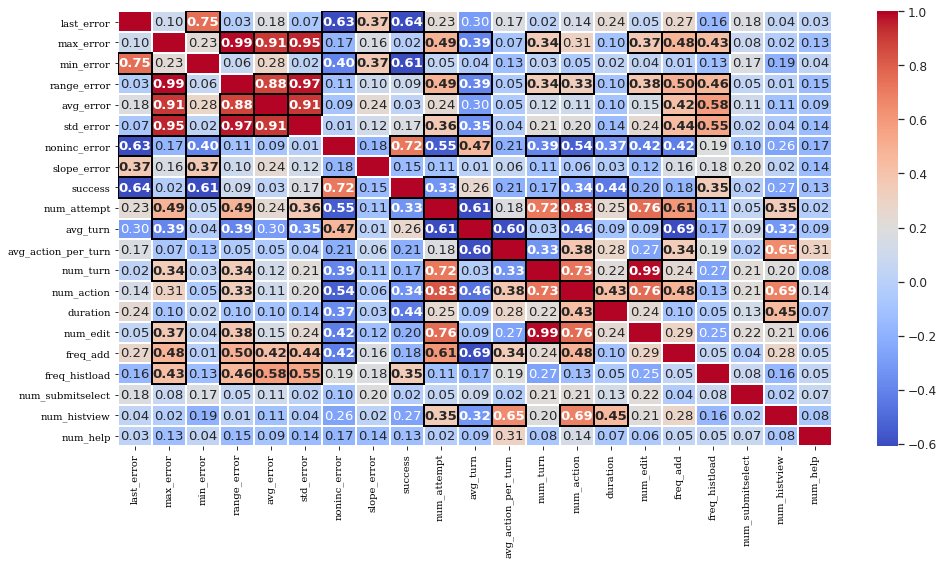

In [20]:
df = tables['task']
corr = df.corr(method='pearson')

corr = corr.round(2)
fig, ax = plt.subplots(figsize=(16, 8)) 
annot_kws = {} 

sns.set(font_scale=1.1)            
sns_plot_1 = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm', 
            robust=True,
            annot=True,
            fmt='.2f',
            annot_kws=annot_kws,
            linewidth=1, #1.5,

            ax=ax)

from matplotlib.patches import Rectangle

for i, annot in enumerate(ax.texts):
    row = i % len(pvalues_df)
    col = int(i / len(pvalues_df))
    p_val = pvalues_df.iloc[row, col]
    annot.set_text('{:.2f}'.format(np.abs(float(annot.get_text()))))
    if 1 - float(annot.get_text()) < 0.001:
        annot.set_visible(False)
    elif p_val < p_thres:
        annot.set_weight('bold')
        annot.set_text('{}'.format(annot.get_text()))

        ax.add_patch(Rectangle((row, col), 1, 1, fill=False, edgecolor='black', lw=2)) #blue

print('Significant (p < 0.05) values (without correction for multiple testing) are in bold and highlighted with a border"')

### Export a separate table for each level.

In [21]:
for key, data in tables.items():
    if key in ['data']:
        continue
        
    file = 'justhink19_log_features_{}_level.csv'.format(key)
    file = output_dir.joinpath(file)
    
    data.to_csv(str(file))
    
    print('{}-level table is exported to {}'.format(key, file))

attempt-level table is exported to ../processed_data/log_features/justhink19_log_features_attempt_level.csv
task-level table is exported to ../processed_data/log_features/justhink19_log_features_task_level.csv
turn-level table is exported to ../processed_data/log_features/justhink19_log_features_turn_level.csv
corpus-level table is exported to ../processed_data/log_features/justhink19_log_features_corpus_level.csv
